In [1]:
'''
Is the movie industry dying? is Netflix the new entertainment king? 
Those were the first questions that lead me to create a dataset focused on movie revenue and analyze it over the last decades. 
But, why stop there? There are more factors that intervene in this kind of thing, like actors, genres, user ratings and more. 
And now, anyone with experience (you) can ask specific questions about the movie industry, and get answers.
'''
%reset

In [52]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='once')

In [86]:
data_raw = pd.read_csv('movies_fixed.csv')
data_raw.head()

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986


### Data preprocessing

In [87]:
def get_column_types(df):
    qualitative = list(data_raw._get_numeric_data().columns)
    quantitative = [c for c in list(df.columns) if c not in qualitative]
    return qualitative, quantitative

qualitative, quantitative = get_column_types(data_raw)

#### Fill 'budget' with regression data. 

In [88]:
%%time
TARGET_BUDGET = 'budget'
from sklearn.preprocessing import minmax_scale
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

def data_preparation_for_budget(df, quantitative):
    result = df.copy()
    result.drop(['name', 'released', 'votes'], axis=1, inplace=True)
    result = pd.get_dummies(data=data_raw, columns=quantitative)   
    return result

def feature_selection_for_budget(train_raw):
    X = train_raw.drop(TARGET_BUDGET, axis=1).copy()
    y = train_raw[TARGET_BUDGET].copy()

    etr = ExtraTreesRegressor()
    etr = etr.fit(X, y)
    model = SelectFromModel(etr, prefit=True)
    no_important_features = model.transform(X).shape[1]
    important_features =pd.DataFrame({
        'feature': list(X.columns),
        'feature_importance': list(etr.feature_importances_)
    }).sort_values(by='feature_importance', ascending=False).head(no_important_features)
    return list(important_features['feature'])
    
train_raw_for_budget = data_preparation_for_budget(data_raw, quantitative)
important_features_for_budget = feature_selection_for_budget(train_raw_for_budget)

CPU times: user 1min 17s, sys: 1.79 s, total: 1min 19s
Wall time: 1min 18s


MSE: 563147990980594.9
R2: 0.5743592747116801
CPU times: user 24.5 s, sys: 162 ms, total: 24.6 s
Wall time: 8.15 s


/Users/slechwar/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


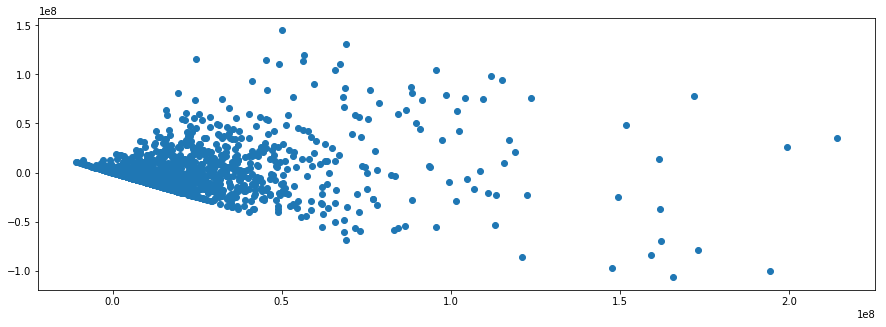

In [89]:
%%time
# Prepare model and fill function.
def prepare_model_for_budget(train_raw, important_features):
    train = train_raw[important_features].copy()
    train[TARGET_BUDGET] = train_raw[TARGET_BUDGET].copy()

    y = train[TARGET_BUDGET]
    X = train.drop(TARGET_BUDGET, axis=1)
    X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=12)
    
    # Training.
    elastic_net = ElasticNet()
    elastic_net.fit(X_train, y_train)
    
    # Evaluation.
    prediction = elastic_net.predict(X_eval)
    print('MSE: {}'.format(mean_squared_error(y_eval, prediction)))
    print('R2: {}'.format(r2_score(y_eval, prediction)))
    
    plt.figure(figsize=(15,5))
    plt.scatter(prediction, y_eval - prediction)
    return elastic_net

def fill_empty_budget(data_raw, quantitative, important_features_for_budget, model_for_budget, scale_min, scale_max):
    result = data_raw.copy()
    df = data_raw.copy()
    index_to_predict = list(df[df['budget'] == 0.0].index)
    df = data_preparation_for_budget(df, quantitative).copy()
    df = df[important_features_for_budget].copy()
    prediction = pd.Series(data=model_for_budget.predict(df.loc[index_to_predict, :]), index=index_to_predict)
    prediction = pd.Series(data=minmax_scale(prediction, feature_range=(scale_min, scale_max)), index=index_to_predict)
    result.loc[index_to_predict, 'budget'] = prediction.apply(lambda x: float(int(x)))
    return result

model_for_budget = prepare_model_for_budget(train_raw_for_budget, important_features_for_budget)

### Transform raw data set

In [91]:
def data_raw_transformation(data_raw):
    result = data_raw.copy()
    budget_scale_min = data_raw.loc[data_raw['budget'] != 0.0, 'budget'].min()
    budget_scale_max = data_raw.loc[data_raw['budget'] != 0.0, 'budget'].max()
    result = fill_empty_budget(
        result, quantitative, important_features_for_budget, model_for_budget, budget_scale_min, budget_scale_max)
    
    # Use regression to fill 0.0's in budget.
    # TBD
    
    # figure out same bin edges!!!
    
    # Ceate bucket'ize version of budget.
#     result['budget_bin'] = pd.qcut(
#         x=result['budget'], q=5, labels=['low', 'medium', 'high', 'extreme'], duplicates='drop')
    # Create bucket'ize version of gross.
#     result['gross_bin'] = pd.qcut(
#         x=result['gross'], q=4, labels=['low', 'medium', 'high', 'extreme'], duplicates='drop')    
    # Create bucket'ize version of votes.
#     result['votes_bin'] = pd.qcut(
#         x=result['votes'], q=4, labels=['few', 'some', 'many', 'a lot of'], duplicates='drop')        
    # Create bucket'ize version of runtime.
    # Create bucket'ize version of released (spring, summer, autumn, winter).
    
    
    return result

data = data_raw_transformation(data_raw)

In [92]:
data

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
0,8000000.0,Columbia Pictures Corporation,USA,Rob Reiner,Adventure,52287414.0,Stand by Me,R,1986-08-22,89,8.1,Wil Wheaton,299174,Stephen King,1986
1,6000000.0,Paramount Pictures,USA,John Hughes,Comedy,70136369.0,Ferris Bueller's Day Off,PG-13,1986-06-11,103,7.8,Matthew Broderick,264740,John Hughes,1986
2,15000000.0,Paramount Pictures,USA,Tony Scott,Action,179800601.0,Top Gun,PG,1986-05-16,110,6.9,Tom Cruise,236909,Jim Cash,1986
3,18500000.0,Twentieth Century Fox Film Corporation,USA,James Cameron,Action,85160248.0,Aliens,R,1986-07-18,137,8.4,Sigourney Weaver,540152,James Cameron,1986
4,9000000.0,Walt Disney Pictures,USA,Randal Kleiser,Adventure,18564613.0,Flight of the Navigator,PG,1986-08-01,90,6.9,Joey Cramer,36636,Mark H. Baker,1986
5,6000000.0,Hemdale,UK,Oliver Stone,Drama,138530565.0,Platoon,R,1987-02-06,120,8.1,Charlie Sheen,317585,Oliver Stone,1986
6,25000000.0,Henson Associates (HA),UK,Jim Henson,Adventure,12729917.0,Labyrinth,PG,1986-06-27,101,7.4,David Bowie,102879,Dennis Lee,1986
7,6000000.0,De Laurentiis Entertainment Group (DEG),USA,David Lynch,Drama,8551228.0,Blue Velvet,R,1986-10-23,120,7.8,Isabella Rossellini,146768,David Lynch,1986
8,9000000.0,Paramount Pictures,USA,Howard Deutch,Comedy,40471663.0,Pretty in Pink,PG-13,1986-02-28,96,6.8,Molly Ringwald,60565,John Hughes,1986
9,15000000.0,SLM Production Group,USA,David Cronenberg,Drama,40456565.0,The Fly,R,1986-08-15,96,7.5,Jeff Goldblum,129698,George Langelaan,1986


## Data analysis

### Budget

/Users/slechwar/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


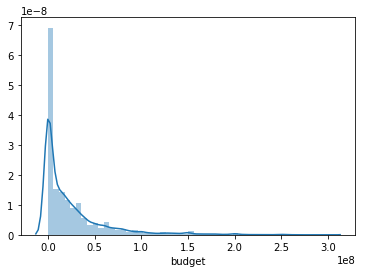

In [55]:
sns.distplot(data_raw['budget'])

In [56]:
data_raw['budget'].value_counts().head()
# We have more than 2000 zero budget movies. Is that correct? Let's check this out...

0.0           2182
20000000.0     207
30000000.0     191
25000000.0     177
15000000.0     170
Name: budget, dtype: int64

In [57]:
data_raw[data_raw['budget'] == 0.0].head()
# "The Name of the Rose" is for sure NOT zero budget movie, I need to treat that as unknown

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
25,0.0,TriStar Pictures,USA,John Badham,Comedy,40697761.0,Short Circuit,PG,1986-05-09,98,6.6,Ally Sheedy,47068,S.S. Wilson,1986
26,0.0,Neue Constantin Film,Italy,Jean-Jacques Annaud,Crime,7153487.0,The Name of the Rose,R,1986-09-24,130,7.8,Sean Connery,86991,Umberto Eco,1986
27,0.0,TriStar Pictures,USA,Sidney J. Furie,Action,24159872.0,Iron Eagle,PG-13,1986-01-17,117,5.3,Louis Gossett Jr.,11304,Kevin Alyn Elders,1986
32,0.0,Gaumont,France,Jean-Jacques Beineix,Drama,2003822.0,Betty Blue,Not specified,1986-11-07,120,7.4,Jean-Hugues Anglade,14562,Philippe Djian,1986
35,0.0,Columbia Pictures Corporation,USA,John G. Avildsen,Action,115103979.0,The Karate Kid Part II,PG,1986-06-20,113,5.9,Pat Morita,58370,Robert Mark Kamen,1986


In [58]:
# What was higher budget movies? Is that real?
data_raw.sort_values(by='budget', ascending=False).head()
# Seems real.
# Idea for data transformation -> create bucket'ize version of variable

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year
4631,300000000.0,Walt Disney Pictures,USA,Gore Verbinski,Action,309420425.0,Pirates of the Caribbean: At World's End,PG-13,2007-05-25,169,7.1,Johnny Depp,514191,Ted Elliott,2007
5293,260000000.0,Walt Disney Animation Studios,USA,Nathan Greno,Animation,200821936.0,Tangled,PG,2010-11-24,100,7.8,Mandy Moore,325621,Dan Fogelman,2010
4637,258000000.0,Columbia Pictures,USA,Sam Raimi,Action,336530303.0,Spider-Man 3,PG-13,2007-05-04,139,6.2,Tobey Maguire,416842,Sam Raimi,2007
6624,250000000.0,Marvel Studios,USA,Anthony Russo,Action,408084349.0,Captain America: Civil War,PG-13,2016-05-06,147,7.9,Chris Evans,442645,Christopher Markus,2016
6194,250000000.0,New Line Cinema,New Zealand,Peter Jackson,Adventure,255119788.0,The Hobbit: The Battle of the Five Armies,PG-13,2014-12-17,144,7.4,Ian McKellen,396797,Fran Walsh,2014


### Gross

In [59]:
data_raw[data_raw['gross'] == 0.0]
# no 0.0's

,budget,company,country,director,genre,gross,name,rating,released,runtime,score,star,votes,writer,year


### Comapny

In [60]:
data_raw['company'].value_counts().shape

(2179,)

In [61]:
data_raw['company'].value_counts().head()

Universal Pictures                        302
Warner Bros.                              294
Paramount Pictures                        259
Twentieth Century Fox Film Corporation    205
New Line Cinema                           172
Name: company, dtype: int64

### Country

In [62]:
data_raw['country'].value_counts().shape

(57,)

In [63]:
data_raw['country'].value_counts().head()

USA        4872
UK          698
France      283
Canada      150
Germany     134
Name: country, dtype: int64

In [64]:
top_5_countries = list(data_raw['country'].value_counts().head(5).index)
data_raw_top_5_countries = data_raw[data_raw['country'].isin(top_5_countries)]

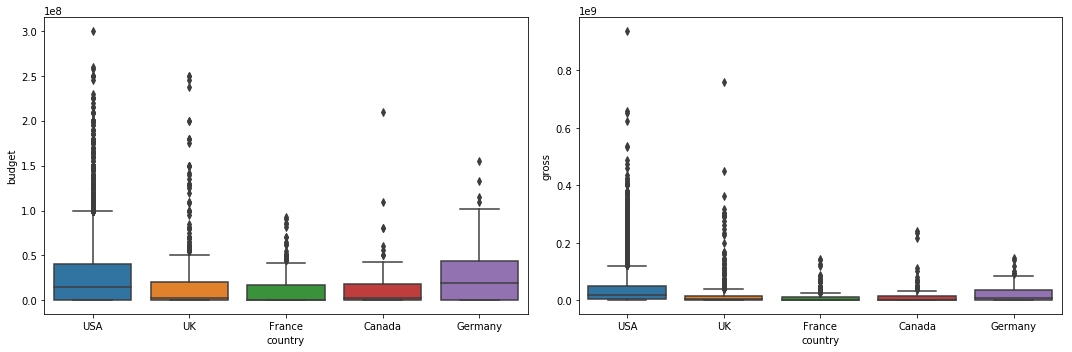

In [65]:
plt.figure(figsize=(15,5))

plt.subplot(121)
sns.boxplot(x='country', y='budget', data=data_raw_top_5_countries)

plt.subplot(122)
sns.boxplot(x='country', y='gross', data=data_raw_top_5_countries)

plt.tight_layout()

### Rating

In [66]:
data_raw['rating'].value_counts()
# Some explainantions:
# https://en.wikipedia.org/wiki/Motion_Picture_Association_of_America_film_rating_system
# Seems that we got a lot "R" restricted movies.

R                3392
PG-13            1995
PG                951
NOT RATED         174
G                 147
UNRATED            71
Not specified      63
NC-17              22
TV-14               1
B15                 1
TV-PG               1
B                   1
TV-MA               1
Name: rating, dtype: int64